# Lecture 9.5: Putting it all together

So far, we've been introducing new methods every lecture. Today, we're going to go over most of the things we've done so far in this course in detail, but with much less explanation. 

Instead, I want this lecture to help you develop your fluency in `sklearn` when working with the tools we've already introduced. We're going to go over loading, chunking, preprocessing, vectorizing, and topic modeling in more detail, without hand-waving the code. This is meant to simulate the process of finding some data with little existing structure and exploring it, using most of the methods we've discussed in class so far. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import LatentDirichletAllocation

import re
import os
import seaborn as sns

Let's look at the `/data/texts` subdirectory.

In [2]:
root_dir = "../data/texts"

book_paths = os.listdir("../data/texts")
print(f'Number of books: {len(book_paths)}')
print(f'Example book file names: {book_paths[:10]}')

Number of books: 42
Example book file names: ['B-Bronte_E-Wuthering_Heights-1847-F.txt', 'A-Harper-Iola_Leroy-1892-F.txt', 'B-Burney-Evelina-1778-F.txt', 'B-Dickens-Bleak_House-1853-M.txt', 'B-Disraeli-Sybil-1845-M.txt', 'A-James-Golden_Bowl-1904-M.txt', 'B-Shelley-Frankenstein-1818-F.txt', 'F-Flaubert-Madame_Bovary-1857-M.txt', 'A-Cather-Antonia-1918-F.txt', 'B-Wells-Time_Machine-1895-M.txt']


Given the above, let's think about what we can get out of this file name alone, assuming the other file names follow the same pattern.

Discuss.

## Data cleaning and preprocessing

Take a look at the following cell. What are we doing? Think through each step and try to anticipate what `df` will look like after the cell has been executed.

In [3]:
def get_txt_file(path):
    with open(path, "r") as f:
        file = f.read()
    return file

texts = [get_txt_file(os.path.join(root_dir, p))
         for p in book_paths]

pattern = re.compile(r"^[ABFO]-(.+)-(.+)-(\d{4})-([FM]).txt$")

columns = ["path", "author", "title", "year", "gender", "text"]

parsed_metadata = [[p] + list(re.search(pattern, p).groups()) + [texts[i]]
                   for i, p in enumerate(book_paths)]

df = pd.DataFrame(parsed_metadata, columns=columns)

df["text"] = df["text"].apply(lambda x: re.split(r"\n+\s*\n*", x))
df["year"] = df.year.astype(int)

df = df.explode("text")

In [4]:
df.head(10)

,path,author,title,year,gender,text
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,CHAPTER I
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,1801.--I have just returned from a visit to my...
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,'Mr. Heathcliff?' I said.
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,A nod was the answer.
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,"'Mr. Lockwood, your new tenant, sir. I do mys..."
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,"'Thrushcross Grange is my own, sir,' he interr..."
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,"The 'walk in' was uttered with closed teeth, a..."
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,When he saw my horse's breast fairly pushing t...
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,'Here we have the whole establishment of domes...
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,"Joseph was an elderly, nay, an old man: very o..."


In [5]:
df["wc"] = df.text.apply(lambda x: len(x.split()))
print(f"Total word count: {df.wc.sum():,}")
df.wc.describe()

Total word count: 5,436,572


count    113321.000000
mean         47.974974
std          66.437598
min           0.000000
25%          12.000000
50%          24.000000
75%          59.000000
max        1489.000000
Name: wc, dtype: float64

Maybe splitting on newline `\n` characters didn't work perfectly. Instead of fiddling with how we chunk our text, is there a quick (albeit destructive) way that we could clean up our data a little bit?

In [6]:
min_length, max_length = (5, 1000)   # Arbitrary! Let's see what happens.
filtered_df = df[(df["wc"] > min_length) & (df["wc"] < max_length)]
print(f"Filtered {len(df) - len(filtered_df):,} samples, {df.wc.sum() - filtered_df.wc.sum():,} words.")

Filtered 10,567 samples, 42,119 words.


In [7]:
filtered_df.head()

,path,author,title,year,gender,text,wc
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,1801.--I have just returned from a visit to my...,115
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,"'Mr. Lockwood, your new tenant, sir. I do mys...",48
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,"'Thrushcross Grange is my own, sir,' he interr...",24
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,"The 'walk in' was uttered with closed teeth, a...",54
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,When he saw my horse's breast fairly pushing t...,42


## Vectorization

Regardless of the specific methods we ultimately employ later on, we will need word counts. 

In [8]:
vectorizer = CountVectorizer(
    stop_words="english",
    strip_accents="unicode",
    encoding="utf-8",
    min_df=.001,     # What does this line mean?
    max_df=.50       # What about this one?
)

count_matrix = vectorizer.fit_transform(filtered_df.text)

id2word = {v: k for k, v in vectorizer.vocabulary_.items()}

In [9]:
count_matrix.shape

(102754, 3510)

Let's quickly inspect our high-frequency words.

In [10]:
sorted_count_idx = np.argsort(-np.array(count_matrix.sum(axis=0)).squeeze())
n_top_words = 15
top_words = [id2word[idx] for idx in sorted_count_idx[:n_top_words]]
top_words


['said',
 'mr',
 'little',
 'like',
 'did',
 'know',
 'man',
 'time',
 'good',
 'mrs',
 'don',
 'come',
 'old',
 'think',
 'say']

Who's Don?

In [11]:
don_idx = vectorizer.vocabulary_["don"]
don_text = filtered_df.iloc[np.argwhere(count_matrix[:, don_idx] > 0)[:, 0]] 
don_text.head(1).text

0    Mr. Heathcliff and his man climbed the cellar ...
Name: text, dtype: object

Remember that `CountVectorizer` uses its default tokenizer when unspecified, which can lead to some unintuitive or undesirable results. Splitting up contractions seems acceptable, though we should remember this when we look at our topic model later on. 

## Feature importance

You know the drill: let's find the most useful features in this count matrix. For our classification task, let's consider author gender info we parsed earlier. Maybe we believe that there's some relationship between author gender and word choice. Let's investigate:

In [12]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score

k = 25

# mutual_info_regression would be better, but takes too long for lecture. 
selector = SelectKBest(f_regression, k=k)
y = filtered_df.gender == "M"
X_words = selector.fit_transform(count_matrix, filtered_df.gender == "M")

In [13]:
top_features = [id2word[w] for w in np.argsort(-selector.scores_)[:k]]
top_features

['emily',
 'margaret',
 'jo',
 'dorothea',
 'elizabeth',
 'meg',
 'lydgate',
 'archer',
 'laurie',
 'said',
 'catherine',
 'montoni',
 'carrie',
 'casaubon',
 'heathcliff',
 'brooke',
 'hale',
 'orville',
 'st',
 'rosamond',
 'madame',
 'bulstrode',
 'beth',
 'robert',
 'linton']

In [14]:
lr_classifier = LogisticRegression().fit(X_words, y)

In [15]:
lr_classifier.coef_

array([[-4.71999007, -3.59187769, -4.37508353, -4.28396845,  4.69896729,
        -4.24878017, -3.57581878, -4.99229697, -3.78377044, -4.54988603,
        -3.23009719, -4.47284803, -1.73367682, -4.60397159, -4.11835643,
        -4.70028805, -0.76485272, -4.38693639, -4.78995397, -4.27128329,
        -4.79527611, -2.99766159, -3.92454843, -0.21351392, -1.14814674]])

In [16]:
[(w, c.item()) for w, c in zip(top_features, lr_classifier.coef_[0])]

[('emily', -4.719990066802508),
 ('margaret', -3.5918776926335516),
 ('jo', -4.375083533196615),
 ('dorothea', -4.283968452923736),
 ('elizabeth', 4.698967291119366),
 ('meg', -4.248780171102808),
 ('lydgate', -3.5758187831263917),
 ('archer', -4.992296972135236),
 ('laurie', -3.7837704399407532),
 ('said', -4.549886031371581),
 ('catherine', -3.230097187882606),
 ('montoni', -4.472848031432669),
 ('carrie', -1.733676822417005),
 ('casaubon', -4.60397158516711),
 ('heathcliff', -4.11835643434585),
 ('brooke', -4.700288052079768),
 ('hale', -0.764852719351273),
 ('orville', -4.386936385529522),
 ('st', -4.789953970445979),
 ('rosamond', -4.271283293137279),
 ('madame', -4.795276105492185),
 ('bulstrode', -2.9976615919837277),
 ('beth', -3.9245484300746916),
 ('robert', -0.21351391511499715),
 ('linton', -1.1481467430389203)]

In [17]:
lr_classifier.intercept_

array([0.75941919])

How do we interpret the above coefficients and the intercept?

In [18]:
print("Mean cross-validated accuracy (all words):", round(np.mean(cross_val_score(LogisticRegression(), count_matrix, y, scoring='accuracy', cv=10)),3))

Mean cross-validated accuracy (all words): 0.694


In [19]:
print("Mean cross-validated accuracy (top words):", round(np.mean(cross_val_score(LogisticRegression(), X_words, y, scoring='accuracy', cv=10)),3))

Mean cross-validated accuracy (top words): 0.686


Is this analysis satisfying? Is the accuracy here good? What does `f_regression` (and, it seems, just a plain `LogisticRegression` classifier) seem to "pick out" of our data, and does it tell us anything interesting? Why or why not? 

## LDA

Let's see if LDA tells us anything more interesting about our data and whether there are actual linguistic features associated with authorial gender. 

In [20]:
lda_model = LatentDirichletAllocation(
    n_components=k,
    doc_topic_prior=1/k,  # This is the default value of doc_topic_prior
    topic_word_prior=1/k, # Ditto. 
    n_jobs=-1,
    max_iter=20
)

doc_topic = lda_model.fit_transform(count_matrix)

In [21]:
def display_topic_words(components, id2word, top_words=10):
    sorted_top_idx = np.argsort(-components)[:, :top_words]
    for i in range(sorted_top_idx.shape[0]): 
        print(f"Feature {i}: {[id2word[id] for id in sorted_top_idx[i]]}")

display_topic_words(lda_model.components_, id2word)

Feature 0: ['door', 'looked', 'little', 'head', 'jo', 'went', 'face', 'room', 'stood', 'eyes']
Feature 1: ['shall', 'say', 'said', 'tell', 'think', 'wish', 'dear', 'hope', 'make', 'know']
Feature 2: ['got', 'didn', 'tom', 'couldn', 'just', 'time', 'good', 'old', 've', 'come']
Feature 3: ['mrs', 'answered', 'did', 'told', 'mean', 'answer', 'said', 'exclaimed', 'laura', 'mother']
Feature 4: ['said', 'yes', 'come', 'let', 'right', 'oh', 'good', 'john', 'don', 'man']
Feature 5: ['mr', 'says', 'sir', 'george', 'man', 'god', 'old', 'looks', 'comes', 'bucket']
Feature 6: ['mr', 'little', 'lydgate', 'mrs', 'time', 'dorothea', 'fact', 'quite', 'felt', 'way']
Feature 7: ['eyes', 'face', 'voice', 'hand', 'heart', 'words', 'looked', 'moment', 'look', 'felt']
Feature 8: ['room', 'table', 'read', 'mrs', 'st', 'paper', 'sat', 'drawing', 'chair', 'archer']
Feature 9: ['child', 'mother', 'doctor', 'tess', 'children', 'dr', 'white', 'death', 'father', 'mrs']
Feature 10: ['began', 'came', 'man', 'time', 

We won't be going over LDA evaluation methods in this course, but here are some subjective criteria to think about: 
* How *coherent* do these topics seem? 
* How *diverse* are the topics? 
* Do some topics seem *highly similar* to other topics? 
* How easy is it to *describe a topic* without just repeating top words?

Let's look at the performance of the transformed `doc_topic` matrix on our author gender classification task. 

In [22]:
print("Mean cross-validated accuracy (top words):", round(np.mean(cross_val_score(LogisticRegression(), doc_topic, y, scoring='accuracy', cv=10)),3))

Mean cross-validated accuracy (top words): 0.575


Oof--what's the baseline again?

In [23]:
(y.sum()/len(y)).item()

0.6036066722463359

In [24]:
lr_features = LogisticRegression().fit(doc_topic, y)
np.argsort(-np.abs(lr_features.coef_))

array([[12, 22,  5, 20, 11,  3, 17, 10,  0, 19, 13, 15, 14,  1,  6,  4,
        18,  8,  7,  2, 24,  9, 23, 21, 16]])

Ok, so only slightly better than chance. What do you make of this result? How do you interpret this in terms of the word-level results we observed earlier?

We should make sure that our `k` value is well-suited to this dataset. Let's evaluate our LDA model with different values of `k` and see how this affects downstream accuracy, if at all.  

In [25]:
eval_results = {"k": [], "acc": []}
cv = 10
for k in range(10, 60, 10):
    lda_eval = LatentDirichletAllocation(
        n_components=k,
        max_iter=10, # fewer iterations, should be more in practice
        n_jobs=-1
    )
    doc_topic_eval = lda_eval.fit_transform(count_matrix)
    
    eval_acc = cross_val_score(
        LogisticRegression(), 
        doc_topic_eval, 
        y, 
        scoring='accuracy', 
        # We're using accuracy here, but we really *should* be using F1.
        cv=cv
    )
    eval_results["acc"] += list(eval_acc)
    eval_results["k"] += [k] * cv 

<Axes: xlabel='k', ylabel='acc'>

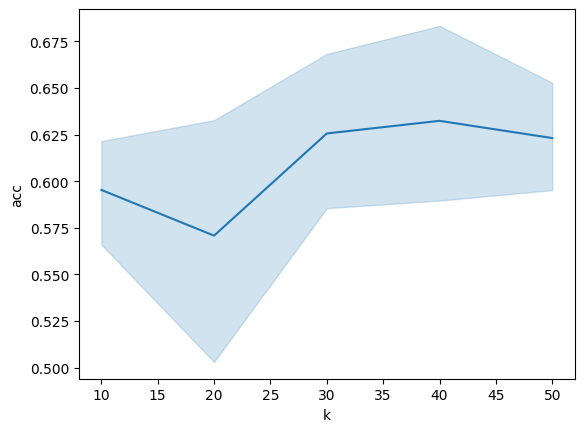

In [26]:
sns.lineplot(pd.DataFrame(eval_results), x="k", y="acc")

If all we cared about here was the accuracy of our classifier, we might be pretty upset at this point!

But what do these results actually say about our data? Is this "negative result" bad? How do we put our findings into words? How do you explain the results?